In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras 
from keras.models import *
from keras.layers import *

from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
directory = '/kaggle/input/large-covid19-ct-slice-dataset/curated_data/curated_data'

data_list = []
for filename in os.listdir(directory):
    for img in os.listdir(directory+"/"+filename):
        data_list.append({'directory':directory+"/"+filename+"/"+img, 'class':filename})

data_df = pd.concat([pd.DataFrame(data_list)], ignore_index=True)

In [3]:
# directory = '/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
# data_df = pd.DataFrame(columns=['directory', 'class'])
# for filename in os.listdir(directory):
#     print(filename)
#     for img in os.listdir(directory+"/"+filename):
#         #print(img)
#         data_df = data_df.append({'directory':directory+"/"+filename+"/"+img, 
#                                  'class':filename}, ignore_index = True)

                                               directory      class
9177   /kaggle/input/large-covid19-ct-slice-dataset/c...  1NonCOVID
6339   /kaggle/input/large-covid19-ct-slice-dataset/c...  1NonCOVID
11691  /kaggle/input/large-covid19-ct-slice-dataset/c...     2COVID
10628  /kaggle/input/large-covid19-ct-slice-dataset/c...     2COVID
6106   /kaggle/input/large-covid19-ct-slice-dataset/c...  1NonCOVID
2COVID P037_95.png
(512, 512, 3)


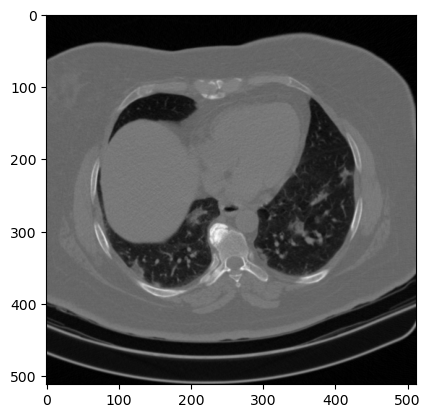

In [4]:
data_df = data_df.sample(frac = 1, random_state=7)
print(data_df.head(5))

test_img_path = data_df.iloc[2][0]
test_img = cv2.imread(test_img_path)
print(test_img_path.split("/")[-2], test_img_path.split("/")[-1])
print(test_img.shape)
plt.imshow(test_img)

## model

In [5]:
batch_size = 64
size = (224,224,3)
img_width = img_hight = size[0]
random_state = 7

classes = list(data_df['class'].unique())



In [6]:
classes

['1NonCOVID', '2COVID', '3CAP']

In [7]:
from sklearn.model_selection import train_test_split

train_df , test_df , _ , _  = train_test_split(data_df, data_df['class'],
                                                                         train_size=0.8, random_state=7,
                                                                         stratify=data_df['class'])


print("Train Split :", round((train_df.shape[0] / data_df['directory'].shape[0]),3))
print("test Split :",round((test_df.shape[0] / data_df['directory'].shape[0]),3))
#print("Test Split :",round((test_df.shape[0] / data_df['directory'].shape[0]),3))

print("training images :" ,len(train_df))
print("validation images :",len(test_df))
#print("testing images :",len(test_df))

Train Split : 0.8
test Split : 0.2
training images : 13683
validation images : 3421


In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(train_df, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes, validate_filenames= False,seed=42,shuffle=True,subset='training')

#Validation Data Generator
val_data = train_gen.flow_from_dataframe(train_df, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes,  validate_filenames= False,seed=42,shuffle=True,subset='validation')

#Test Data Generator
test_data = test_gen.flow_from_dataframe(test_df, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes, subset=None, validate_filenames= False, seed=42,shuffle=False)


Found 10947 non-validated image filenames belonging to 3 classes.
Found 2736 non-validated image filenames belonging to 3 classes.
Found 3421 non-validated image filenames belonging to 3 classes.


In [8]:
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Input
import tensorflow as tf
from keras.layers import Input,Dropout, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Reshape, Multiply, Add, Lambda,Flatten
from keras.models import Model
import tensorflow_addons as tfa


def squeeze_excitation_block(inputs, ratio=8):
    b, _, _, c = inputs.shape
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation="relu", use_bias=False)(x)
    x = Dense(c, activation="sigmoid", use_bias=False)(x)
#     x = tf.math.multiply(inputs,x)
    x = keras.layers.multiply([inputs,x])
    return x


# Define the input shape
input_shape = size


# Define the input tensor
inputs = Input(shape=input_shape)

# Apply convolutional layers 1
conv1 = Conv2D(32, (5, 5), padding='same', activation='relu')(inputs)
mish1 = tfa.activations.mish(conv1)
# Apply Squeeze and Excitation block
se1 = squeeze_excitation_block(mish1)
pool1= MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(se1)
drop1 =Dropout(0.5)(pool1)

# Apply convolutional layers 2
conv2 = Conv2D(32, (5, 5), padding='same', activation='relu')(drop1)
mish2 = tfa.activations.mish(conv2)
# Apply Squeeze and Excitation block
se2 = squeeze_excitation_block(mish2)
pool2= MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(se2)
drop2 =Dropout(0.5)(pool2)

# Apply convolutional layers 3
conv3 = Conv2D(64, (5, 5), padding='same', activation='relu')(drop2)
mish3 = tfa.activations.mish(conv3)
# Apply Squeeze and Excitation block
se3 = squeeze_excitation_block(mish3)
pool3= MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(se3)
drop3 =Dropout(0.5)(pool3)

# Apply convolutional layers 4
conv4 = Conv2D(128, (5, 5), padding='same', activation='relu')(drop3)
mish4 = tfa.activations.mish(conv4)
# Apply Squeeze and Excitation block
se4 = squeeze_excitation_block(mish4)
pool4= MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(se4)
drop4 =Dropout(0.5)(pool4)

# Apply convolutional layers 4
conv5 = Conv2D(256, (5, 5), padding='same', activation='relu')(drop4)

flatten = Flatten()(conv5)

# Apply global average pooling and fully connected layers
#x = GlobalAveragePooling2D()(conv5)
x = Dense(256,activation='relu')(flatten)
#x = tfa.activations.mish(x)
outputs = Dense(3, activation='softmax')(x)


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
import tensorflow_addons as tfa
# Define the model
model = Model(inputs=inputs, outputs=outputs)
# Compile the model
model.compile(optimizer=tfa.optimizers.RectifiedAdam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


SavingModel = ModelCheckpoint(filepath='ct_mish_adam.h5', 
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=False)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 30,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=6, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

callbacks = [ SavingModel,  learning_rate_reduction]

In [11]:
results=model.fit(
    train_data,
    validation_data= val_data,
    epochs=70,
    callbacks=callbacks
  )

Epoch 1/70


2023-07-09 20:54:29.057553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


172/172 [==============================] - ETA: 0s - loss: 0.8644 - accuracy: 0.5682
Epoch 1: val_accuracy improved from -inf to 0.61440, saving model to ct_mish_adam.h5
172/172 [==============================] - 197s 1s/step - loss: 0.8644 - accuracy: 0.5682 - val_loss: 0.7958 - val_accuracy: 0.6144 - lr: 0.0010
Epoch 2/70
172/172 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.7708
Epoch 2: val_accuracy improved from 0.61440 to 0.76462, saving model to ct_mish_adam.h5
172/172 [==============================] - 101s 587ms/step - loss: 0.5514 - accuracy: 0.7708 - val_loss: 0.5709 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 3/70
172/172 [==============================] - ETA: 0s - loss: 0.4339 - accuracy: 0.8310
Epoch 3: val_accuracy improved from 0.76462 to 0.81615, saving model to ct_mish_adam.h5
172/172 [==============================] - 101s 589ms/step - loss: 0.4339 - accuracy: 0.8310 - val_loss: 0.4773 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 4/70
172/172 [=

Text(0, 0.5, 'losses')

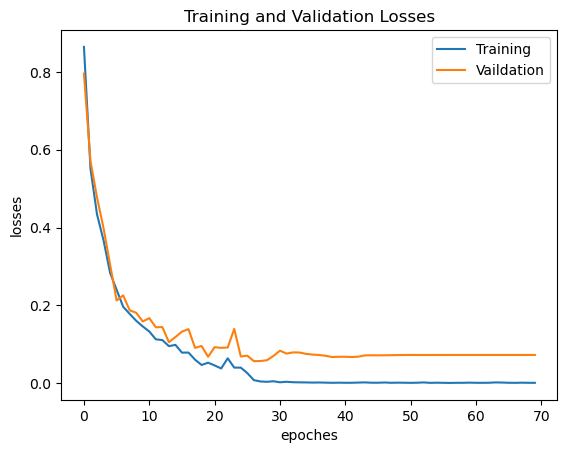

In [12]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Training','Vaildation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoches')
plt.ylabel('losses')

Text(0, 0.5, 'accuracy')

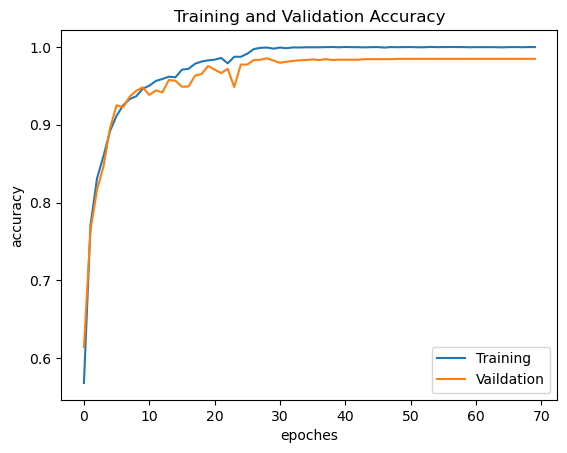

In [13]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['Training','Vaildation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.ylabel('accuracy')

In [14]:
pd.DataFrame.to_csv(pd.DataFrame(results.history),'his_ct_mish_adam.csv', index=False)

In [15]:
#pd.DataFrame.to_csv(pd.DataFrame(results.history),'paper_lstm_his.csv', index=False)

# result

In [10]:
import tensorflow_addons as tfa
model=keras.models.load_model('/kaggle/input/se-block-model-ct/ct_mish_adam.h5')

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
y_pred= model.predict(test_data)

54/54 [==============================] - 55s 797ms/step


In [12]:
import numpy as np
y_pred1=np.argmax(y_pred,axis=1)
y_pred1

array([0, 2, 0, ..., 1, 0, 1])

In [13]:
from sklearn.metrics import accuracy_score,  confusion_matrix
confusion_matrix = confusion_matrix(test_data.labels,y_pred1)
print(confusion_matrix)

accuracy_score(test_data.labels,y_pred1)*100

[[1358   21    0]
 [  29 1487    3]
 [   0    1  522]]


98.42151417714119

In [14]:
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['NORMAL','COVID19','PNEUMONIA'],
                     columns = ['NORMAL','COVID19','PNEUMONIA'])
cm_df

,NORMAL,COVID19,PNEUMONIA
NORMAL,1358,21,0
COVID19,29,1487,3
PNEUMONIA,0,1,522


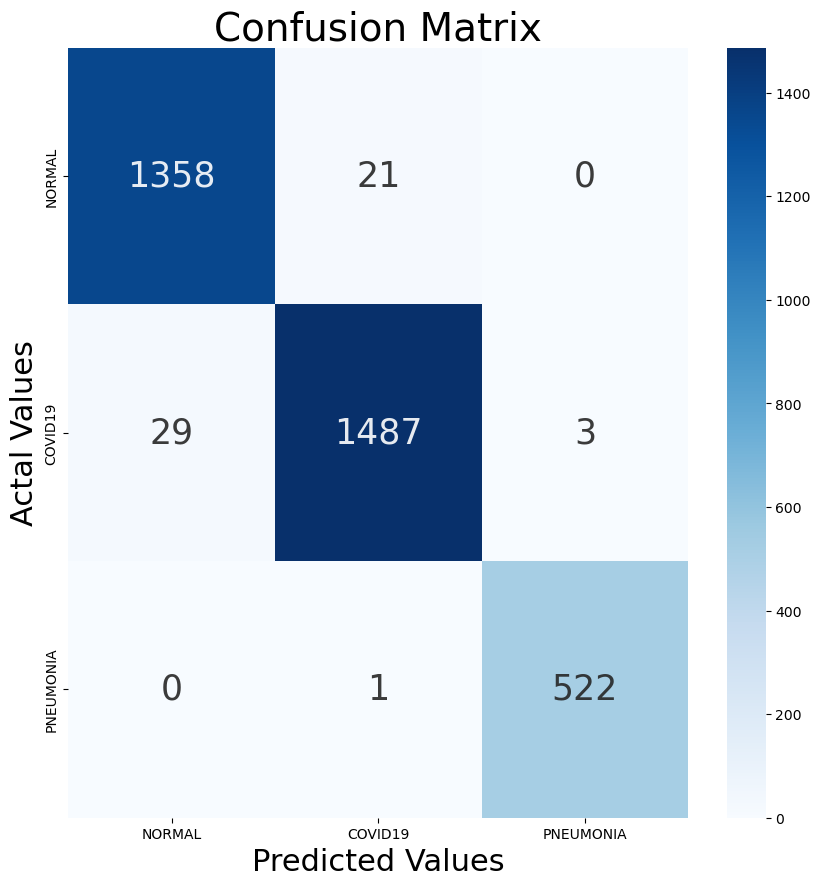

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
#sns.heatmap(cm_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),fmt="")

sns.heatmap(cm_df, annot=True,cmap='Blues',fmt="",annot_kws={'fontsize':25,'alpha':0.9})
# ,annot_kws={'fontsize':16,
#            'fontstyle':'italic',
#            'color':"k",
#            'alpha':0.9,
#            'backgroundcolor':'w',
#            'verticalalignment':'center',
#            }
plt.title('Confusion Matrix',fontsize=28)
plt.ylabel('Actal Values',fontsize=22)
plt.xlabel('Predicted Values',fontsize=22)
plt.show()

In [16]:
from sklearn.metrics import classification_report
target_names =  ['NORMAL','COVID19','PNEUMONIA']
report=classification_report(test_data.labels,y_pred1, target_names=target_names)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.98      0.98      0.98      1379
     COVID19       0.99      0.98      0.98      1519
   PNEUMONIA       0.99      1.00      1.00       523

    accuracy                           0.98      3421
   macro avg       0.99      0.99      0.99      3421
weighted avg       0.98      0.98      0.98      3421



In [17]:
reportdic=classification_report(test_data.labels,y_pred1, target_names=target_names, output_dict=True)
print(reportdic)
reportdic_df = pd.DataFrame(reportdic)
print(reportdic_df.head())

{'NORMAL': {'precision': 0.9790915645277577, 'recall': 0.9847715736040609, 'f1-score': 0.9819233550253073, 'support': 1379}, 'COVID19': {'precision': 0.9854208084824387, 'recall': 0.9789335088874259, 'f1-score': 0.9821664464993394, 'support': 1519}, 'PNEUMONIA': {'precision': 0.9942857142857143, 'recall': 0.9980879541108987, 'f1-score': 0.9961832061068704, 'support': 523}, 'accuracy': 0.9842151417714119, 'macro avg': {'precision': 0.9862660290986369, 'recall': 0.9872643455341285, 'f1-score': 0.9867576692105057, 'support': 3421}, 'weighted avg': {'precision': 0.9842247600526252, 'recall': 0.9842151417714119, 'f1-score': 0.9842113287361263, 'support': 3421}}
                NORMAL      COVID19   PNEUMONIA  accuracy    macro avg  \
precision     0.979092     0.985421    0.994286  0.984215     0.986266   
recall        0.984772     0.978934    0.998088  0.984215     0.987264   
f1-score      0.981923     0.982166    0.996183  0.984215     0.986758   
support    1379.000000  1519.000000  52

In [18]:
reportdic_df = reportdic_df.drop(columns=['macro avg', 	'weighted avg','accuracy'])

reportdic_df = reportdic_df.drop(labels='support', axis=0)
reportdic_df= reportdic_df.mul(100)
print(reportdic_df.head())

              NORMAL    COVID19  PNEUMONIA
precision  97.909156  98.542081  99.428571
recall     98.477157  97.893351  99.808795
f1-score   98.192336  98.216645  99.618321


In [19]:
reportdic_df

,NORMAL,COVID19,PNEUMONIA
precision,97.909156,98.542081,99.428571
recall,98.477157,97.893351,99.808795
f1-score,98.192336,98.216645,99.618321


In [20]:
import plotly.graph_objects as go
import pandas as pd

# Create a sample DataFrame
df = reportdic_df

# Define the bar chart colors

#colors = ['rgb(255, 51, 51)', 'rgb(51, 204, 51)', 'rgb(51, 51, 255)']
#colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)']

# Create the bar chart trace
fig = go.Figure(data=[
    go.Bar(name='COVID19', x=df.index, y=df['COVID19']),
    go.Bar(name='NORMAL', x=df.index, y=df['NORMAL']),
    go.Bar(name='PNEUMONIA', x=df.index, y=df['PNEUMONIA'])
])

# # Set the bar chart title and axis labels
fig.update_layout(title='Performance Metrics', xaxis_title='Metrics',
yaxis_title='Score',font=dict(size=22))

fig.update_yaxes(range=[80, 100])

# Display the bar chart
fig.show()

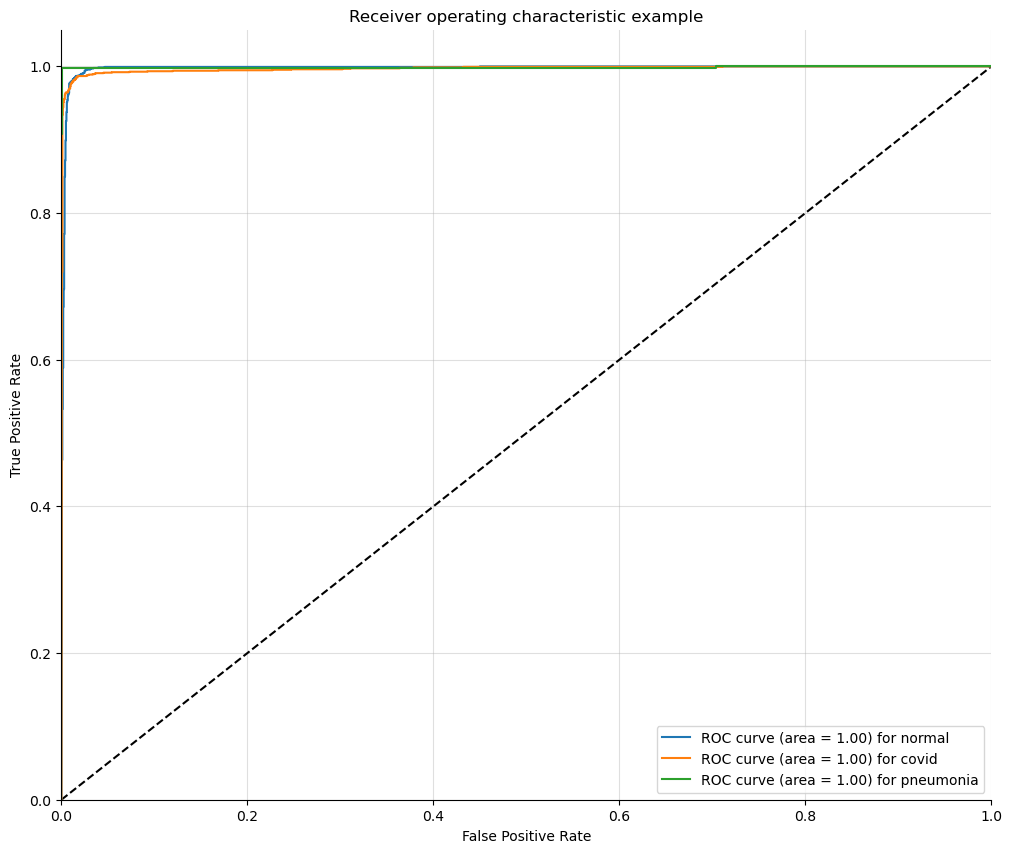

In [21]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

class_to_label_map = {2 : 'pneumonia', 1 : 'covid', 0 : 'normal'}
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(test_data.classes,y_pred, n_classes=3, figsize=(12, 10))

In [28]:
pd.DataFrame.to_csv(reportdic_df, 'reportresults.csv', index=False)